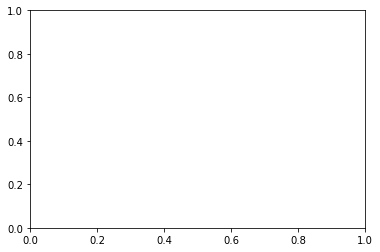

In [1]:
import matplotlib.pyplot as plt
plt.gca().clear()

data = [ ("big data", 100, 15), ("Hadoop", 95, 25), ("Python", 75, 50),
         ("R", 50, 40), ("machine learning", 80, 20), ("statistics", 20, 60),
         ("data science", 60, 70), ("analytics", 90, 3),
         ("team player", 85, 85), ("dynamic", 2, 90), ("synergies", 70, 0),
         ("actionable insights", 40, 30), ("think out of the box", 45, 10),
         ("self-starter", 30, 50), ("customer focus", 65, 15),
         ("thought leadership", 35, 35)]


from matplotlib import pyplot as plt

def fix_unicode(text: str) -> str:
    return text.replace(u"\u2019", "'")


In [17]:
import re
from bs4 import BeautifulSoup
import requests

url = "https://www.oreilly.com/ideas/what-is-data-science"
html = requests.get(url).text
soup = BeautifulSoup(html, 'html.parser') #'html5lib'

#print(soup)
content = soup.find("div", "main-post-radar-content")   # find article-body div
#print(content)
regex = r"[\w']+|[\.]"                       # matches a word or a period

document = []

for paragraph in content("p"):
    words = re.findall(regex, fix_unicode(paragraph.text))
    document.extend(words)

from collections import defaultdict

transitions = defaultdict(list)
for prev, current in zip(document, document[1:]):
    transitions[prev].append(current)

def generate_using_bigrams() -> str:
    current = "."   # this means the next word will start a sentence
    result = []
    while True:
        next_word_candidates = transitions[current]    # bigrams (current, _)
        current = random.choice(next_word_candidates)  # choose one at random
        result.append(current)                         # append it to results
        if current == ".": return " ".join(result)     # if "." we're done


In [18]:
trigram_transitions = defaultdict(list)
starts = []

for prev, current, next in zip(document, document[1:], document[2:]):

    if prev == ".":              # if the previous "word" was a period
        starts.append(current)   # then this is a start word

    trigram_transitions[(prev, current)].append(next)

def generate_using_trigrams() -> str:
    current = random.choice(starts)   # choose a random starting word
    prev = "."                        # and precede it with a '.'
    result = [current]
    while True:
        next_word_candidates = trigram_transitions[(prev, current)]
        next_word = random.choice(next_word_candidates)

        prev, current = current, next_word
        result.append(current)

        if current == ".":
            return " ".join(result)

In [19]:
from typing import List, Dict

# Type alias to refer to grammars later
Grammar = Dict[str, List[str]]

grammar = {
    "_S"  : ["_NP _VP"],
    "_NP" : ["_N",
             "_A _NP _P _A _N"],
    "_VP" : ["_V",
             "_V _NP"],
    "_N"  : ["data science", "Python", "regression"],
    "_A"  : ["big", "linear", "logistic"],
    "_P"  : ["about", "near"],
    "_V"  : ["learns", "trains", "tests", "is"]
}

def is_terminal(token: str) -> bool:
    return token[0] != "_"

def expand(grammar: Grammar, tokens: List[str]) -> List[str]:
    for i, token in enumerate(tokens):
        # If this is a terminal token, skip it.
        if is_terminal(token): continue

        # Otherwise, it's a non-terminal token,
        # so we need to choose a replacement at random.
        replacement = random.choice(grammar[token])

        if is_terminal(replacement):
            tokens[i] = replacement
        else:
            # Replacement could be e.g. "_NP _VP", so we need to
            # split it on spaces and splice it in.
            tokens = tokens[:i] + replacement.split() + tokens[(i+1):]

        # Now call expand on the new list of tokens.
        return expand(grammar, tokens)

    # If we get here we had all terminals and are done
    return tokens

def generate_sentence(grammar: Grammar) -> List[str]:
    return expand(grammar, ["_S"])

In [20]:
from typing import Tuple
import random

def roll_a_die() -> int:
    return random.choice([1, 2, 3, 4, 5, 6])

def direct_sample() -> Tuple[int, int]:
    d1 = roll_a_die()
    d2 = roll_a_die()
    return d1, d1 + d2

def random_y_given_x(x: int) -> int:
    """equally likely to be x + 1, x + 2, ... , x + 6"""
    return x + roll_a_die()

def random_x_given_y(y: int) -> int:
    if y <= 7:
        # if the total is 7 or less, the first die is equally likely to be
        # 1, 2, ..., (total - 1)
        return random.randrange(1, y)
    else:
        # if the total is 7 or more, the first die is equally likely to be
        # (total - 6), (total - 5), ..., 6
        return random.randrange(y - 6, 7)

def gibbs_sample(num_iters: int = 100) -> Tuple[int, int]:
    x, y = 1, 2 # doesn't really matter
    for _ in range(num_iters):
        x = random_x_given_y(y)
        y = random_y_given_x(x)
    return x, y

def compare_distributions(num_samples: int = 1000) -> Dict[int, List[int]]:
    counts = defaultdict(lambda: [0, 0])
    for _ in range(num_samples):
        counts[gibbs_sample()][0] += 1
        counts[direct_sample()][1] += 1
    return counts

def sample_from(weights: List[float]) -> int:
    """returns i with probability weights[i] / sum(weights)"""
    total = sum(weights)
    rnd = total * random.random()      # uniform between 0 and total
    for i, w in enumerate(weights):
        rnd -= w                       # return the smallest i such that
        if rnd <= 0: return i          # weights[0] + ... + weights[i] >= rnd

In [21]:
from collections import Counter

# Draw 1000 times and count
draws = Counter(sample_from([0.1, 0.1, 0.8]) for _ in range(1000))
assert 10 < draws[0] < 190   # should be ~10%, this is a really loose test
assert 10 < draws[1] < 190   # should be ~10%, this is a really loose test
assert 650 < draws[2] < 950  # should be ~80%, this is a really loose test
assert draws[0] + draws[1] + draws[2] == 1000

In [22]:
documents = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

K = 4

# a list of Counters, one for each document
document_topic_counts = [Counter() for _ in documents]

# a list of Counters, one for each topic
topic_word_counts = [Counter() for _ in range(K)]

# a list of numbers, one for each topic
topic_counts = [0 for _ in range(K)]

# a list of numbers, one for each document
document_lengths = [len(document) for document in documents]

distinct_words = set(word for document in documents for word in document)
W = len(distinct_words)

D = len(documents)

def p_topic_given_document(topic: int, d: int, alpha: float = 0.1) -> float:
    """
    The fraction of words in document _d_
    that are assigned to _topic_ (plus some smoothing)
    """
    return ((document_topic_counts[d][topic] + alpha) /
            (document_lengths[d] + K * alpha))

def p_word_given_topic(word: str, topic: int, beta: float = 0.1) -> float:
    """
    The fraction of words assigned to _topic_
    that equal _word_ (plus some smoothing)
    """
    return ((topic_word_counts[topic][word] + beta) /
            (topic_counts[topic] + W * beta))

def topic_weight(d: int, word: str, k: int) -> float:
    """
    Given a document and a word in that document,
    return the weight for the kth topic
    """
    return p_word_given_topic(word, k) * p_topic_given_document(k, d)

def choose_new_topic(d: int, word: str) -> int:
    return sample_from([topic_weight(d, word, k)
                        for k in range(K)])

random.seed(0)
document_topics = [[random.randrange(K) for word in document]
                   for document in documents]

for d in range(D):
    for word, topic in zip(documents[d], document_topics[d]):
        document_topic_counts[d][topic] += 1
        topic_word_counts[topic][word] += 1
        topic_counts[topic] += 1


In [23]:
import tqdm

for iter in tqdm.trange(1000):
    for d in range(D):
        for i, (word, topic) in enumerate(zip(documents[d],
                                              document_topics[d])):

            # remove this word / topic from the counts
            # so that it doesn't influence the weights
            document_topic_counts[d][topic] -= 1
            topic_word_counts[topic][word] -= 1
            topic_counts[topic] -= 1
            document_lengths[d] -= 1

            # choose a new topic based on the weights
            new_topic = choose_new_topic(d, word)
            document_topics[d][i] = new_topic

            # and now add it back to the counts
            document_topic_counts[d][new_topic] += 1
            topic_word_counts[new_topic][word] += 1
            topic_counts[new_topic] += 1
            document_lengths[d] += 1

for k, word_counts in enumerate(topic_word_counts):
    for word, count in word_counts.most_common():
        if count > 0:
            print(k, word, count)

topic_names = ["Big Data and programming languages",
               "Python and statistics",
               "databases",
               "machine learning"]

for document, topic_counts in zip(documents, document_topic_counts):
    print(document)
    for topic, count in topic_counts.most_common():
        if count > 0:
            print(topic_names[topic], count)
    print()

100%|██████████| 1000/1000 [00:00<00:00, 1766.75it/s]

0 Java 3
0 Big Data 3
0 Hadoop 2
0 HBase 1
0 C++ 1
0 Spark 1
0 Storm 1
0 programming languages 1
0 MapReduce 1
0 Cassandra 1
0 deep learning 1
1 HBase 2
1 neural networks 2
1 Postgres 2
1 MongoDB 2
1 machine learning 2
1 Cassandra 1
1 numpy 1
1 decision trees 1
1 deep learning 1
1 databases 1
1 MySQL 1
1 NoSQL 1
1 artificial intelligence 1
1 scipy 1
2 regression 3
2 Python 2
2 R 2
2 libsvm 2
2 scikit-learn 2
2 mathematics 1
2 support vector machines 1
2 Haskell 1
2 Mahout 1
3 statistics 3
3 probability 3
3 Python 2
3 R 2
3 pandas 2
3 statsmodels 2
3 C++ 1
3 artificial intelligence 1
3 theory 1
['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']
Big Data and programming languages 7

['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']
Python and statistics 5

['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas']
Python and statistics 2
databases 2
machine learning 2

['R', 'Python', 'statistics', 'regression', 'probability']
machine learning 3
databa

In [25]:
from linear_algebra import dot, Vector
import math

def cosine_similarity(v1: Vector, v2: Vector) -> float:
    return dot(v1, v2) / math.sqrt(dot(v1, v1) * dot(v2, v2))

assert cosine_similarity([1., 1, 1], [2., 2, 2]) == 1, "same direction"
assert cosine_similarity([-1., -1], [2., 2]) == -1,    "opposite direction"
assert cosine_similarity([1., 0], [0., 1]) == 0,       "orthogonal"

colors = ["red", "green", "blue", "yellow", "black", ""]
nouns = ["bed", "car", "boat", "cat"]
verbs = ["is", "was", "seems"]
adverbs = ["very", "quite", "extremely", ""]
adjectives = ["slow", "fast", "soft", "hard"]

def make_sentence() -> str:
    return " ".join([
        "The",
        random.choice(colors),
        random.choice(nouns),
        random.choice(verbs),
        random.choice(adverbs),
        random.choice(adjectives),
        "."
    ])


## Advanced

In [28]:
from deep_learning import Optimizer, Layer

class EmbeddingOptimizer(Optimizer):
    """
    Optimized for the case where there are
    only embedding layers with single id updates.
    """
    def __init__(self, learning_rate: float) -> None:
        self.lr = learning_rate

    def step(self, layer: Layer) -> None:
        for param, grad in zip(layer.params(), layer.grads()):
            # Find the first (only) row with nonzero values.
            for idx, row in enumerate(grad):
                if row[0] != 0:
                    break

            # Then update just that row.
            for j in range(len(row)):
                param[idx][j] -= grad[idx][j] * self.lr

<Figure size 432x288 with 0 Axes>